In [1]:
!pip install torch torchvision matplotlib numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import numpy as np                          # To handle arrays (images and labels)
import matplotlib.pyplot as plt             # To show image plots
import torch                                # Main PyTorch library
import torch.nn as nn                       # For neural network layers
from torchvision import models, transforms  # Pretrained models & image transformations
from torch.utils.data import Dataset, DataLoader  # To create datasets and load in batches
from PIL import Image                       # To handle images
from sklearn.metrics import classification_report  # To print accuracy, precision, recall etc.

Shape of train images: (3882, 28, 28)
Shape of train labels: (3882, 1)


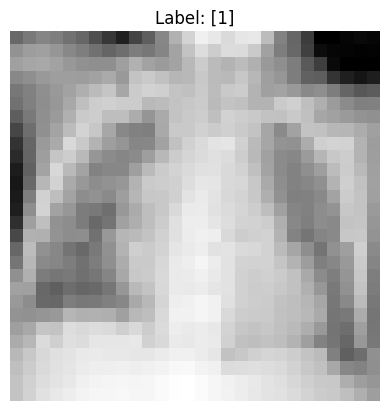

In [3]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')

print("Shape of train images:", train_images.shape)
print("Shape of train labels:", train_labels.shape)

# Let's show one image
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.show()


In [4]:
from torchvision import transforms

# 🔁 Transformation for training images with more augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),                              # Convert NumPy array to PIL image
    transforms.Resize((299, 299)),                        # Resize for InceptionV3
    transforms.Grayscale(num_output_channels=3),          # Convert to 3-channel RGB
    transforms.RandomHorizontalFlip(),                    # Flip horizontally
    transforms.RandomRotation(15),                        # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Slightly change brightness & contrast
    transforms.ToTensor(),                                # Convert to PyTorch tensor
    transforms.Normalize([0.5]*3, [0.5]*3)                 # Normalize channels to [-1, 1]
])

# ✅ Validation & Test transform — NO augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
import torch
import numpy as np

# 💻 Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔢 Ensure training labels are a flat array
train_labels = np.array(train_labels).flatten()

# ✅ Count number of samples per class
class_counts = np.bincount(train_labels)  # [Normal, Pneumonia]
print("Class distribution:", class_counts)

# 🧮 Inverse class frequency = higher weight for minority class
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights.to(device)
print("Class weights:", class_weights)

# ✅ Use class weights in loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)


Class distribution: [ 388 3494]
Class weights: tensor([0.0026, 0.0003], device='cuda:0')


In [11]:
from torch.utils.data import Dataset

class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
# ✅ Load each .npy file individually
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')

val_images = np.load('val_images.npy')
val_labels = np.load('val_labels.npy')

test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')


In [13]:
# Create Dataset objects
train_dataset = PneumoniaDataset(train_images, train_labels, transform=train_transform)
val_dataset = PneumoniaDataset(val_images, val_labels, transform=test_transform)
test_dataset = PneumoniaDataset(test_images, test_labels, transform=test_transform)


In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
model = models.inception_v3(pretrained=True)   # Load InceptionV3 with pre-trained weights

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 31.5MB/s] 


In [16]:
# Disable auxiliary classifier (for simplicity)
model.aux_logits = False

# Replace the final fully-connected layer
num_ftrs = model.fc.in_features        # Number of inputs to the last layer
model.fc = nn.Linear(num_ftrs, 2)      # Change output to 2 classes

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)  # Move model to device


Using device: cuda


In [18]:
criterion = nn.CrossEntropyLoss()                   # Good for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for faster learning

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    model.train()  # Set the model to training mode

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()               # Clear gradients from previous step
            outputs = model(images)             # Forward pass: model makes predictions
            loss = criterion(outputs, labels)   # Calculate how wrong the predictions are
            loss.backward()                     # Backpropagation: calculate gradients
            optimizer.step()                    # Update the model using gradients

            # Track stats
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)    # Get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"Training Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

In [20]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5)


Epoch 1/5


/tmp/ipython-input-11-3547306552.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


Training Loss: 0.1618, Accuracy: 93.35%

Epoch 2/5
Training Loss: 0.1115, Accuracy: 95.70%

Epoch 3/5
Training Loss: 0.0981, Accuracy: 96.42%

Epoch 4/5
Training Loss: 0.0925, Accuracy: 96.70%

Epoch 5/5
Training Loss: 0.0950, Accuracy: 96.70%


In [21]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))

In [22]:
evaluate_model(model, test_loader, device)

/tmp/ipython-input-11-3547306552.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])



Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.71      0.80       234
   Pneumonia       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624

